# RunPod Train

## Imports

In [1]:
import transformers as trsf
print("Transformers:", trsf.__version__)

Transformers: 4.47.1


In [2]:
import os
import copy
from dataclasses import dataclass
import pickle

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import Tensor

#from datasets import Dataset

from tqdm import tqdm

from transformers import (
    BitsAndBytesConfig,
    Gemma2ForSequenceClassification,
    Gemma2Model,
    GemmaTokenizerFast,
    Gemma2Config,
    AutoTokenizer,
    AutoModel,
    PreTrainedTokenizerBase, 
    EvalPrediction,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    get_cosine_schedule_with_warmup,
)

from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType

from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split

import ModelsUtils as Utils
import Configurations as Configs
#import wsdm_modelutils as Utils

In [3]:
import peft as pft
print("Peft:", pft.__version__)

Peft: 0.14.0


In [4]:
print('Torch version:', torch.__version__)
print('Torch is build with CUDA:', torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Torch device : {device}')
print('------------------------------')

Torch version: 2.5.1+cu118
Torch is build with CUDA: True
Torch device : cuda
------------------------------


In [5]:
device_ids = list(range(torch.cuda.device_count()))
device_ids

[0]

## Config

In [6]:
config_file = 'Configs.py'
manager = Configs.ConfigManager(config_file)

config = manager.micro

config.config_name

'micro_gemma2_2b_fp16_4bit'

### Paths

In [7]:
base_model_path = config.basemodel_path
peft_model_path = '../Checkpoints/'
checkpoint_name = "Original_notrain"
dataframe_path = config.train_data
dataframe_swapab_path = config.swapab_data


## Data

In [8]:
df = pd.read_csv(dataframe_path)
df_swap = pd.read_csv(dataframe_swapab_path)
df.head(1)

C:\Users\Ohmatheus\AppData\Local\Temp\ipykernel_9632\1540438253.py:1: DtypeWarning: Columns (0,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(dataframe_path)
C:\Users\Ohmatheus\AppData\Local\Temp\ipykernel_9632\1540438253.py:2: DtypeWarning: Columns (0,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_swap = pd.read_csv(dataframe_swapab_path)


,id,prompt,response_a,response_b,winner,language,class_label,prompt_len,response_a_len,response_b_len,...,prompt_chinese,prompt_round_balance,prompt_curly_balance,prompt_json,prompt_sentiment,response_a_sentiment,response_b_sentiment,cosine_similarity_a,cosine_similarity_b,cosine_similarity_diff
0,53567,What is the difference between marriage licens...,A marriage license is a legal document that al...,A marriage license and a marriage certificate ...,model_b,NaN,1,192,3096,3592,...,0.0,0,0,0,0.077778,0.058469,0.139458,0.705321,0.629803,0.075518


In [9]:
df['prompt'] = df['prompt'].astype(str)
df['response_a'] = df['response_a'].astype(str)
df['response_b'] = df['response_b'].astype(str)

df_swap['prompt'] = df_swap['prompt'].astype(str)
df_swap['response_a'] = df_swap['response_a'].astype(str)
df_swap['response_b'] = df_swap['response_b'].astype(str)

## Tokenize

In [10]:
tokenizer = AutoTokenizer.from_pretrained(base_model_path)
tokenizer.add_eos_token = True      # We'll add <eos> at the end
tokenizer.padding_side = "right"

In [11]:
df = df.sample(frac=config.sample_size, random_state=config.random_seed)
df_swap = df_swap.sample(frac=config.sample_size, random_state=config.random_seed)

In [12]:
def tokenize_df(row):
    return Utils.tokenize(tokenizer, [row['prompt']], [row['response_a']], [row['response_b']], max_length=config.max_length)

df['tokens'] = df.apply(tokenize_df, axis=1)
df['len'] = df['prompt_len'] + df['response_a_len'] + df['response_b_len']

df_swap['tokens'] = df_swap.apply(tokenize_df, axis=1)
df_swap['len'] = df_swap['prompt_len'] + df_swap['response_a_len'] + df_swap['response_b_len']

In [13]:
df.shape

(351, 72)

## Split

In [14]:
df_train, df_valid = train_test_split(df, test_size=config.validation_size, random_state=config.random_seed)
df_train_swap, df_valid_swap = train_test_split(df_swap, test_size=config.validation_size, random_state=config.random_seed)

## Data Loader

In [15]:
# Prepare dataset and dataloader
dataset_train = Utils.ChatbotArenaDataset(df_train, tokenizer, max_length=config.max_length)
dataloader_train = Utils.DataLoader(dataset_train, batch_size=config.train_batch, shuffle=True)

dataset_valid = Utils.ChatbotArenaDataset(df_valid, tokenizer, max_length=config.max_length)
dataloader_valid = Utils.DataLoader(dataset_valid, batch_size=config.eval_batch, shuffle=True)

dataset_train_swap = Utils.ChatbotArenaDataset(df_train_swap, tokenizer, max_length=config.max_length)
dataloader_train_swap = Utils.DataLoader(dataset_train_swap, batch_size=config.train_batch, shuffle=True)

In [16]:
next(iter(dataset_train))['features']

tensor([ 1.8400e+02,  1.2330e+03,  2.3460e+03,  3.3000e+01,  2.5900e+02,
         4.4200e+02,  5.0000e+00,  2.0000e+01,  4.0000e+01,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  5.0000e+00,
         0.0000e+00,  1.7000e+01,  2.2000e+01,  0.0000e+00,  6.0000e+00,
         1.0000e+01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  7.0000e+00,  1.6000e+01,
         0.0000e+00,  7.0000e+00,  1.6000e+01,  3.8000e+01,  3.2800e+02,
         5.7400e+02,  0.0000e+00,  6.0000e+00,  4.2000e+01,  7.7174e-01,
         7.0722e-01,  7.1824e-01,  2.1739e-02,  8.1103e-03,  1.1509e-02,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  9.2308e-02,  0.0000e+00,
         5.3765e-01,  5.3835e-01, -6.9773e-04])

In [17]:
next(iter(dataset_train_swap))['features']


tensor([1.8400e+02, 2.3460e+03, 1.2330e+03, 3.3000e+01, 4.4200e+02, 2.5900e+02,
        5.0000e+00, 4.0000e+01, 2.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 5.0000e+00, 0.0000e+00, 0.0000e+00, 2.2000e+01, 1.7000e+01,
        0.0000e+00, 1.0000e+01, 6.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.6000e+01, 7.0000e+00,
        0.0000e+00, 1.6000e+01, 7.0000e+00, 3.8000e+01, 5.7400e+02, 3.2800e+02,
        0.0000e+00, 4.2000e+01, 6.0000e+00, 7.7174e-01, 7.1824e-01, 7.0722e-01,
        2.1739e-02, 1.1509e-02, 8.1103e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 9.2308e-02,
        5.3835e-01, 5.3765e-01, 6.9773e-04])

## Model

In [18]:
predictionModel = Utils.custom_load_model_chkpt(
                        config,
                        checkpointName="Original_notrain",
                        device=device
                        )

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


In [19]:
predictionModel

PreferencePredictionModel(
  (gemma_model): PeftModel(
    (base_model): LoraModel(
      (model): Gemma2Model(
        (embed_tokens): Embedding(256000, 2304, padding_idx=0)
        (layers): ModuleList(
          (0-25): 26 x Gemma2DecoderLayer(
            (self_attn): Gemma2Attention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2304, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2304, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
     

In [20]:
optimizer = optim.AdamW([
    {'params': predictionModel.gemma_model.parameters(), 'lr': config.base_model_lr},     # Lower learning rate for transformer layers
    {'params': predictionModel.feature_fc.parameters(), 'lr': config.feature_fc_lr},      # Higher learning rate for custom layers
    {'params': predictionModel.classifier.parameters(), 'lr': config.classifier_lr},      # Higher learning rate for custom layers
], weight_decay=0.01)

#optimizer = optim.AdamW(predictionModel.parameters(), weight_decay=0.01)
#optimizer = optim.Adam(predictionModel.parameters())

num_training_steps = len(dataloader_train) * config.n_epochs
num_warmup_steps = int(0.05 * num_training_steps)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps,
    num_cycles=0.27
)

## Train

In [21]:
predictionModel.gemma_model.config.hidden_size

2304

In [22]:
history = Utils.train_model(predictionModel, dataloader_train, dataloader_train_swap, dataloader_valid, optimizer, config, scheduler=lr_scheduler, device=device)

  0%|          | 0/158 [00:00<?, ?row/s]`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


f:\Projects\Kaggle\2_WSDMCup_Multilingual_Chatbot_Arena\.venv\Lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
  0%|          | 0/18 [00:00<?, ?row/s]The 'batch_size' argument of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'max_batch_size' argument instead.
The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.
100%|██████████| 18/18 [00:20<00:00,  1.12s/row]


Epoch 1 Finished
Accumulated Train Loss: 0.6948403942434094
Accumulated Train Accuracy: 0.5047619047619047
Valid Loss: 0.6883784466319613, Valid Accuracy : 0.5555555555555556
0.6883784466319613 val loss is better than previous inf, saving checkpoint_lossBest, epoch:  1
0.5555555555555556 val accuracy is better than previous 0, saving checkpoint_accBest, epoch:  1
-----------------------------------------------------------------


100%|██████████| 18/18 [00:19<00:00,  1.11s/row]


Epoch 2 Finished
Accumulated Train Loss: 0.6935024650036534
Accumulated Train Accuracy: 0.49523809523809526
Valid Loss: 0.6879530582163069, Valid Accuracy : 0.6111111111111112
0.6879530582163069 val loss is better than previous 0.6883784466319613, saving checkpoint_lossBest, epoch:  2
0.6111111111111112 val accuracy is better than previous 0.5555555555555556, saving checkpoint_accBest, epoch:  2
-----------------------------------------------------------------


100%|██████████| 18/18 [00:18<00:00,  1.03s/row]


Epoch 3 Finished
Accumulated Train Loss: 0.6878877863099303
Accumulated Train Accuracy: 0.6063492063492063
Valid Loss: 0.6876086923811171, Valid Accuracy : 0.5833333333333334
0.6876086923811171 val loss is better than previous 0.6879530582163069, saving checkpoint_lossBest, epoch:  3
-----------------------------------------------------------------


100%|██████████| 18/18 [00:19<00:00,  1.10s/row]


Epoch 4 Finished
Accumulated Train Loss: 0.684897313389597
Accumulated Train Accuracy: 0.580952380952381
Valid Loss: 0.6855878896183438, Valid Accuracy : 0.5555555555555556
0.6855878896183438 val loss is better than previous 0.6876086923811171, saving checkpoint_lossBest, epoch:  4
-----------------------------------------------------------------


100%|██████████| 18/18 [00:19<00:00,  1.10s/row]


Epoch 5 Finished
Accumulated Train Loss: 0.6720181782788868
Accumulated Train Accuracy: 0.6317460317460317
Valid Loss: 0.6821259889337752, Valid Accuracy : 0.5555555555555556
0.6821259889337752 val loss is better than previous 0.6855878896183438, saving checkpoint_lossBest, epoch:  5
-----------------------------------------------------------------


100%|██████████| 18/18 [00:19<00:00,  1.07s/row]

Epoch 6 Finished
Accumulated Train Loss: 0.6692938974386529
Accumulated Train Accuracy: 0.6031746031746031
Valid Loss: 0.6850918332735697, Valid Accuracy : 0.5833333333333334
-----------------------------------------------------------------


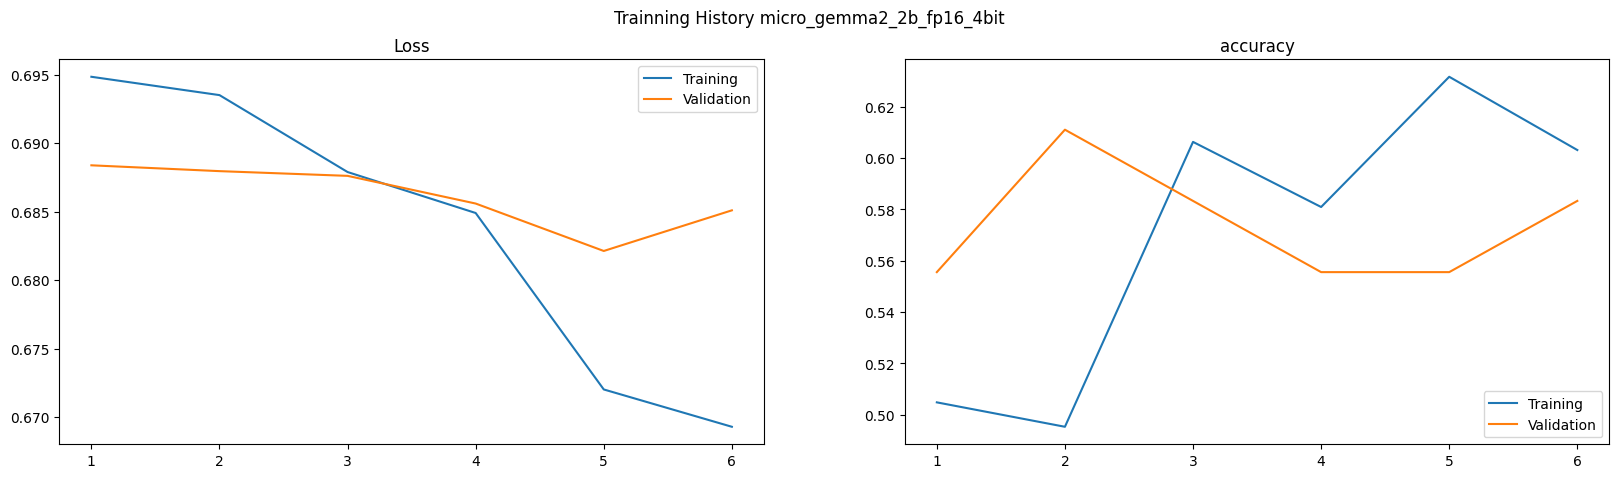

In [23]:
Utils.plot_model_history(history, "Trainning History")

In [24]:
!runpodctl remove pod $RUNPOD_POD_ID

'runpodctl' is not recognized as an internal or external command,
operable program or batch file.
